In [10]:
import pennylane as qml
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from pennylane import numpy as np
from pennylane.templates import RandomLayers

In [11]:
n_epochs = 30
n_layers = 1
n_train = 1000
n_test = 100 # change to 100


SAVE_PATH = "quanvolution/"
PREPROCESS = True           # False --> skip quantum processing and load data from SAVE_PATH
np.random.seed(0)

In [ ]:
x_train  = np.load("x_train.npy")
y_train  = np.load("y_train.npy")

x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")

x_val_test = np.load("x_val.npy")
y_val_test = np.load("y_val.npy")

In [29]:
x_val_test = x_test[300:400]
y_val_test = y_test[300:400]

In [30]:
dev = qml.device("default.mixed", wires=4)

# Random circuit parameters
rand_params = np.random.uniform(high=2*np.pi, size=(n_layers, 4))

# To convert the function into a QNode running on dev, we apply the qnode() decorator
@qml.qnode(dev)
def circuit(phi):
    # Higher order encoding of 4 classical input values
    for j in range(4):
        qml.Hadamard(wires=j)
        qml.RZ(np.pi*phi[j], wires=j)

    qml.CNOT(wires=[0, 1])
    qml.RZ(np.pi*phi[0]*phi[1], wires=0)
    qml.CNOT(wires=[0, 1])

    qml.CNOT(wires=[0, 2])
    qml.RZ(np.pi*phi[0]*phi[2], wires=0)
    qml.CNOT(wires=[0, 2])

    qml.CNOT(wires=[0, 3])
    qml.RZ(np.pi*phi[0]*phi[3], wires=0)
    qml.CNOT(wires=[0, 3])

    qml.CNOT(wires=[1, 2])
    qml.RZ(np.pi*phi[1]*phi[2], wires=1)
    qml.CNOT(wires=[1, 2])
    
    qml.CNOT(wires=[1, 3])
    qml.RZ(np.pi*phi[1]*phi[3], wires=1)
    qml.CNOT(wires=[1, 3])
    
    qml.CNOT(wires=[2, 3])
    qml.RZ(np.pi*phi[2]*phi[3], wires=2)
    qml.CNOT(wires=[2, 3])


    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    for j in range(4):
        qml.DepolarizingChannel(0.1, wires=[j])

    # Measurement (expect. val.) producing 4 classical outputs
    return [qml.expval(qml.PauliY(j)) for j in range(4)]

In [31]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit"""
    out = np.zeros((75, 75, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 150, 2):
        for k in range(0, 150, 2):
            # Process a 2x2 region with the quantum circuit
            q_results = circuit(
                [image[j, k, 0], image[j, k + 1, 0],
                 image[j + 1, k, 0], image[j + 1, k + 1, 0]]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [32]:
if PREPROCESS == True:
    # q_train_images = []
    # print("Quantum pre-processing of train images:")
    # for idx, img in enumerate(x_train):
    #     print(f"{idx + 1}/{n_train - 500}        ", end="\r")
    #     q_train_images.append(quanv(img))
    # q_train_images = np.asarray(q_train_images)

    q_test_val_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(x_val_test):
        print(f"{idx + 1}/{n_test}        ", end="\r")
        q_test_val_images.append(quanv(img))
    q_test_val_images = np.asarray(q_test_val_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_val_test_images_higher_order_noisy_100.npy", q_test_val_images)



Quantum pre-processing of test images:


In [19]:
# Save pre-processed images
np.save(SAVE_PATH + "q_test_images_higher_order_noisy_100.npy", q_test_images)
# np.save(SAVE_PATH + "q_train_images_higher_order_500.npy", q_train_images)


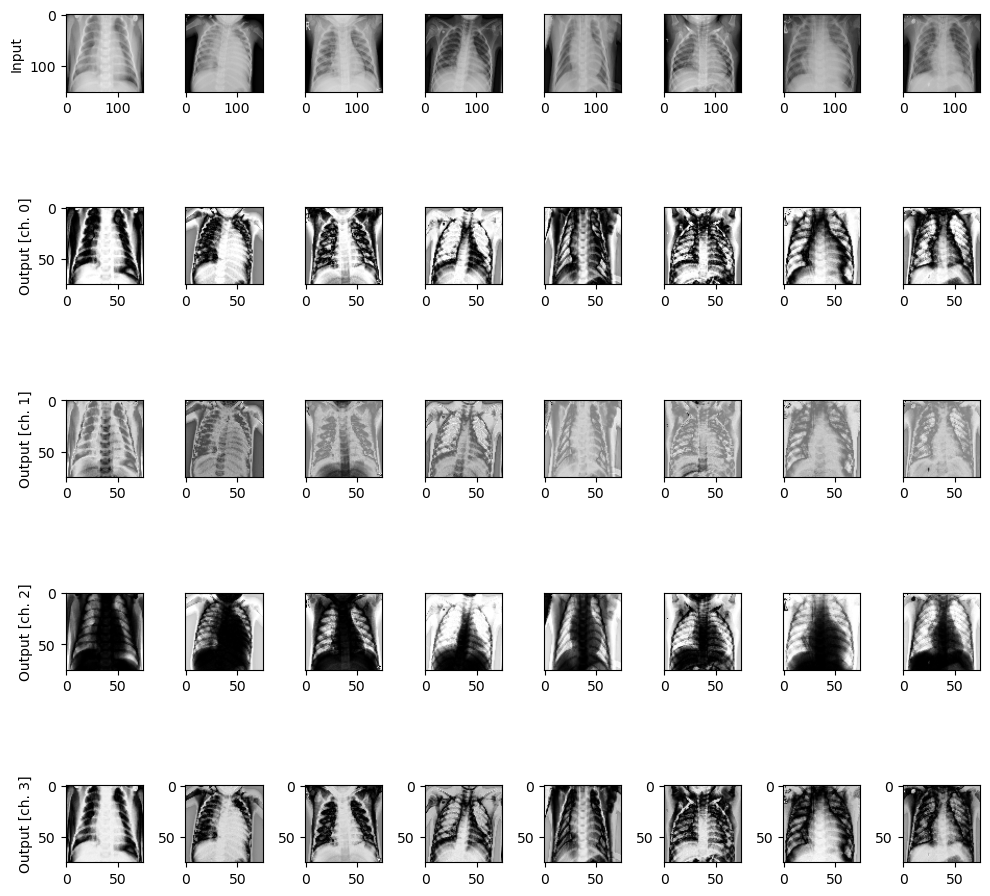

In [20]:
n_samples = 8
n_channels = 4

# Load pre-processed images
q_train_images_angle = np.load(SAVE_PATH + "q_train_images_higher_order_200.npy")
q_test_images_angle = np.load(SAVE_PATH + "q_test_images_higher_order_100.npy")

fig, axes = plt.subplots(1+n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(x_train[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel(f"Output [ch. {c}]")
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images_angle[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.savefig(f'out_q_layer_{n_samples}_samples_threshold_300.png', dpi=300, facecolor='w')
plt.show()

In [25]:
def qmodel():
  """Initializes and returns a Keras model to be trained"""

  model = keras.models.Sequential()

  #quanvolutional layer
  model.add(keras.layers.MaxPooling2D((2, 2)))

  #convolution 2
  model.add(keras.layers.Conv2D(8, kernel_size=(2, 2), strides=2, activation='relu'))
  model.add(keras.layers.MaxPooling2D((2, 2)))
  model.add(keras.layers.Dropout(0.2))

  #convolution 3
  model.add(keras.layers.Conv2D(16, kernel_size=(2, 2), strides=2, activation='relu'))
  model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

  model.add(keras.layers.Flatten())

  #Possibility to add Fully connected layer, following the dropout layer here
  model.add(keras.layers.Dense(128, activation='relu'))
  model.add(keras.layers.Dropout(0.2))

  #Fully connected layer
  model.add(keras.layers.Dense(1, activation='sigmoid'))


  model.compile(
      optimizer='adam',
      loss="binary_crossentropy",
      metrics=["accuracy"],
  )

  return model

In [26]:
def cmodel():
  """Initializes and returns a Keras model to be trained"""

  model = keras.models.Sequential()

  #quanvolution-like convolutional layer
  model.add(keras.layers.Conv2D(4, kernel_size=(2, 2), strides=2, activation='relu'))
  model.add(keras.layers.MaxPooling2D((2, 2)))

  #convolution 2
  model.add(keras.layers.Conv2D(8, kernel_size=(2, 2), strides=2, activation='relu'))
  model.add(keras.layers.MaxPooling2D((2, 2)))
  model.add(keras.layers.Dropout(0.2))

  #convolution 3
  model.add(keras.layers.Conv2D(16, kernel_size=(2, 2), strides=2, activation='relu'))
  model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

  model.add(keras.layers.Flatten())

  #Possibility to add Fully connected layer, following the dropout layer here
  model.add(keras.layers.Dense(128, activation='relu'))
  model.add(keras.layers.Dropout(0.2))

  #Fully connected layer
  model.add(keras.layers.Dense(1, activation='sigmoid'))


  model.compile(
      optimizer='adam',
      loss="binary_crossentropy",
      metrics=["accuracy"],
  )

  return model

In [28]:
q_model_angle = qmodel()

q_history_angle = q_model_angle.fit(q_train_images_angle, y_train,
                        validation_data=(q_train_images_angle, y_test),
                        batch_size=4, epochs=100, verbose=2)

ImportError: cannot import name 'deserialize_keras_object' from partially initialized module 'keras.saving.legacy.serialization' (most likely due to a circular import) (/Users/yerassyl/anaconda3/lib/python3.11/site-packages/keras/saving/legacy/serialization.py)